# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 9. Статистика и байесовские классификаторы.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком
    * *или* вставив ее в ноутбук посредством `Edit -> Insert Image` при редактировании markdown-ячейки (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). **<font color="red">Неправильно вставленные фотографии могут не передаться при отправке.</font>** Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* **В решениях поясняйте, чем вы пользуетесь**, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.



**Баллы за задание:**

* Задача 3 &mdash; 30 баллов
* Задача 4 &mdash; 30 баллов
* Задача 3 &mdash; 50 баллов
* Задача 4 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad9
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
!pip install -q optuna datasets wandb transformers==4.30 accelerate>=0.20.1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
sns.set(palette='Set2')
import optuna
from scipy.stats import ttest_rel
from datasets import Dataset
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
import wandb
import os

---
### Задача 1.   

**a).** Пусть $X_1,...,X_n$ выборка из некоторого распределения $\mathsf{P}$, причем ${\sf D} X_1=\sigma^2<+\infty$, и $\sigma$ неизвестно.
Рассмотрим оценку $S^2 = \overline{X^2}-\overline{X}^2$ дисперсии $\sigma^2$.

Докажите, что $S^2=\frac1n\sum\limits_{i=1}^n\left(X_i-\overline{X}\right)^2$.

**b).** Оценка $\widehat{\theta}$ называется несмещенной оценкой параметра $\theta$ если для любого $\theta \in \Theta$ выполнено $\mathsf{E}_\theta \widehat{\theta} = \theta$. Иначе говоря, какое бы ни оказалось истинное значение параметра $\theta$, рассматривая оценку $\widehat{\theta}$ в среднем будем получать именно $\theta$.

Является ли статистика $S^2$ несмещенной оценкой $\sigma^2$?

*Подсказка.* Посчитайте математическое ожидание случайной величины $S^2$. Используйте для этого известные вам свойства математического ожидания.

*Решение теоретических задач прикрепил отдельным файлом*

 ---
### Задача 2.   

Пусть $X_1, ..., X_n$ &mdash; выборка из распределения $\mathcal{N}(0, \sigma^2)$. В качестве оценок $\sigma^2$ обычно используют $S^2$ или $\frac{n}{n-1}S^2$. Что можно сказать про их несмещенность?

**Ответ:** *Решение теоретических задач прикрепил отдельным файлом. Краткий итог: $S^2$ - смещенная, $\frac{n}{n-1}S^2$ - несмещенная оценка*

**1.** Теперь проверьте это на практике. Для каждой из приведенных выше оценок $\widehat{\theta}$ выполните следующие действия.


* Вычислите $k = 500$ независимых оценок $\widehat{\theta}_1, ... , \widehat{\theta}_k$ по независимым выборкам $(X_1^1, ... , X_n^1), ... , (X_1^k, ... , X_n^k)$, сгенерированным из распределения $\mathcal{N}(0, \sigma^2)$. Для генерации выберите какое-то истинное значение $\sigma$. Далее вычислите среднее этих оценок, которое обозначим $\widetilde{\theta}$.

* Визуализируйте полученные значения, построив на **одном** графике точки $(\widehat{\theta}_1, y), ... , (\widehat{\theta}_k, y)$ и среднее оценок $(\widetilde{\theta}, y)$, где $y$ &mdash; произвольные различные (например, 0 и 1) координаты для двух различных типов оценок.

* Повторите действие три раза для $n \in \{10, 100, 500\}$. В итоге получится три графика для различных $n$, на каждом из которых изображено поведение двух типов оценок и их среднее.

Используйте приведенный **шаблон** для визуализации значений.

**Внимание!** Следите за информативностью и наглядностью графиков. Например, пустых пространств должно быть как можно меньше, ничего не должно быть скомкано, вся нужная информация должна быть представлена. Посмотрите <a target="_blank" href="https://miptstats.github.io/courses/ad_fivt/lecture1_2.pdf">презентацию</a> по оформлению домашних заданий. **Если график чему-то не удовлетворяет, оценка будет снижена.**

**Решение:**

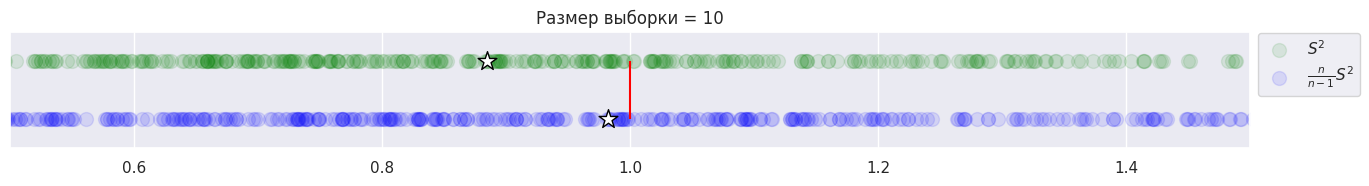

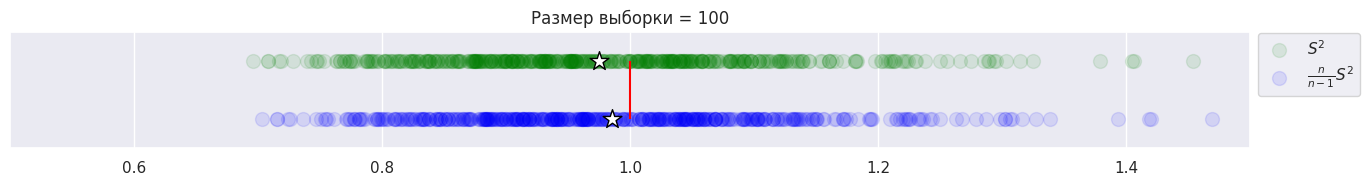

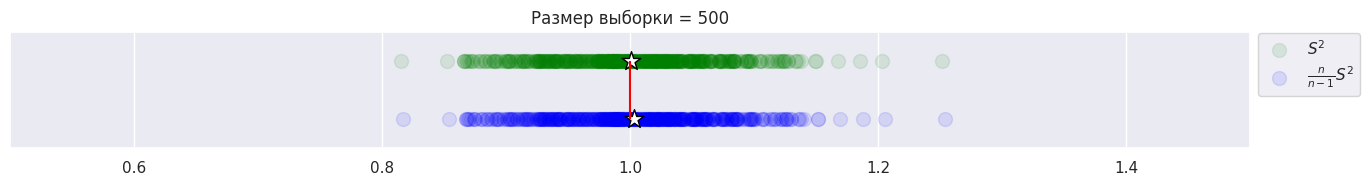

In [3]:
sigma = 1  # какое-то истинное значение сигмы)
k = 500

for n in [10,100,500]:
    samples = sps.norm(scale=sigma).rvs(size=(k,n))
    plt.figure(figsize=(16,1.5))

    theta_hat = (samples**2).mean(axis=1) - (samples.mean(axis=1))**2
    plt.scatter(theta_hat, np.ones(k), alpha=0.1, s=100, color='green', label=r'$S^2$')
    plt.scatter(theta_hat.mean(), 1, marker='*', s=200, color='w', edgecolors='black')
    theta_hat_unbiased = theta_hat * n / (n-1)
    plt.scatter(theta_hat_unbiased, np.zeros(k), alpha=0.1, s=100, color='blue', label=r'$\frac{n}{n-1}S^2$')
    plt.scatter(theta_hat_unbiased.mean(), 0, marker='*', s=200, color='w', edgecolors='black')

    plt.vlines(1, 0, 1, color='r')
    plt.title(f'Размер выборки = {n}')
    plt.yticks([])
    plt.legend(loc='lower left', bbox_to_anchor=(1,0.38))
    plt.xlim((0.5,1.5))
    plt.ylim((-0.5,1.5))
    plt.show()

*По графикам видно, что с ростом размера выборки $n$:*  
- *среднее <span style="color:blue">несмещенной</span> оценки почти не двигается (остается вблизи 1), что наглядно иллюстрирует ее несмещенность*   
- *среднее <span style="color:green">смещенной</span> оценки приближается к среднему <span style="color:blue">несмещенной</span> оценки снизу. Это логично, поскольку для <span style="color:green">смещенной</span> оценки верно $E(S^2)=\frac{n-1}{n}\sigma^2<\sigma^2$ (вывел в теор. задаче), т.е. это нижняя оценка дисперсии (и с ростом $n$ ее среднее приближается к дисперсии и среднему <span style="color:blue">несмещенной</span> оценки снизу)*  
- *разброс обеих оценок уменьшается (следствие ЗБЧ)*   

**2.** Изучим поведение среднего оценок из первого пункта при росте размера выборки. Постройте график зависимости $\widetilde{\theta}$ от $n$ для двух типов оценок. Для вычисления зависимости нужно один раз сгенерировать выборки из пункта 1 достаточно большого размера (не более 500) и посчитать оценки по подвыборкам, используя <a href="https://miptstats.github.io/courses/python/05_numpy.html#2.1-Математические-операции">функции</a> из `numpy`. Использовать циклы, а так же функции, разворачивающиеся в цикл (например, `np.vectorize`), запрещено.

**Решение:**

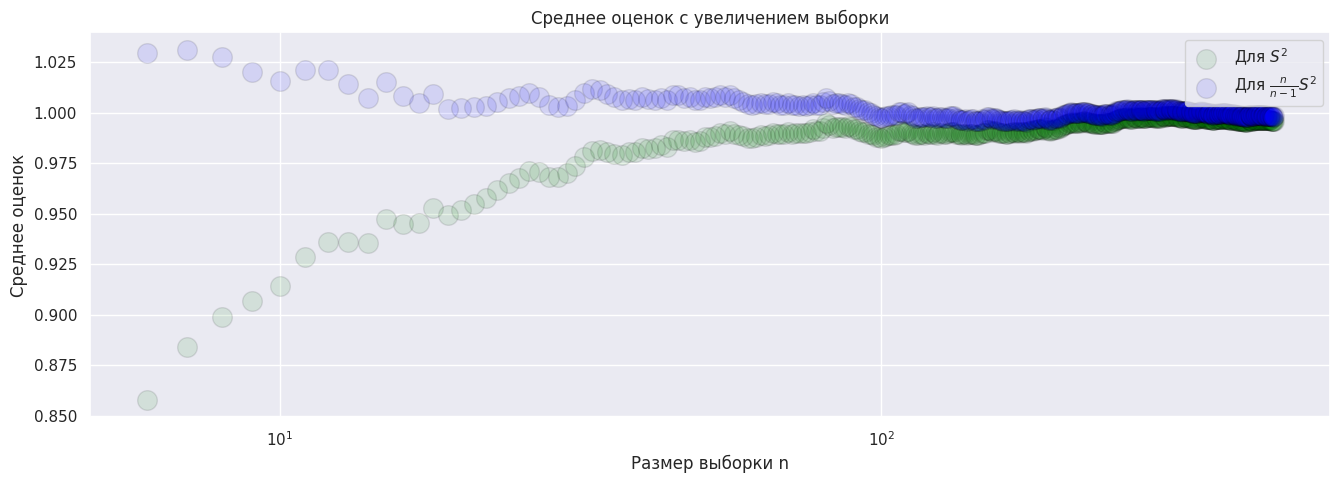

In [4]:
samples = sps.norm(scale=1).rvs(size=(k,450))  # удобно взять n == 450 != 500 для самопроверки по размерностям
ns = np.arange(1,samples.shape[1]+1)

plt.figure(figsize=(16,5))
ax = plt.gca()
ax.set_xscale('log')

theta_hat = ((np.cumsum(samples**2, axis=1) / ns)  -  ((np.cumsum(samples, axis=1) / ns) ** 2))[:,5:]
plt.scatter(ns[5:], theta_hat.mean(axis=0), s=200, alpha=0.1, color='green', edgecolors='black', label=r'Для $S^2$')
theta_hat_unbiased = theta_hat * ns[5:] / (ns[5:]-1)
plt.scatter(ns[5:], theta_hat_unbiased.mean(axis=0), s=200, alpha=0.1, color='blue', edgecolors='black', label=r'Для $\frac{n}{n-1}S^2$')

plt.title(f'Среднее оценок с увеличением выборки')
plt.legend()
plt.xlabel('Размер выборки n')
plt.ylabel('Среднее оценок')
plt.show()

Сделайте вывод о том, что такое свойство несмещенности. Подтверждают ли сделанные эксперименты полученное в теоретических задачах свойство несмещенности (или отсутствие этого свойства) данных оценок?

*Для ПМФ:* поясните, почему в лабораторных по физике при оценке погрешности иногда используют $n-1$ в знаменателе, а не $n$.

*Замечание.* Для ответа на вопрос достаточно понимания текущего материала, ничего из физики знать не требуется.

**Вывод:**

*Этот эксперимент подтверждает выявленную ранее закономерность: с ростом размера выборки $n$ среднее <span style="color:green">смещенной</span> оценки приближается к среднему <span style="color:blue">несмещенной</span> оценки снизу, причем среднее <span style="color:blue">несмещенной</span> оценки остается в окрестности 1 ($\sigma^2$). Как упоминалось выше, в теор. задаче было доказано, что для <span style="color:green">смещенной</span> оценки верно $E(S^2)=\frac{n-1}{n}\sigma^2<\sigma^2=E(\frac{n}{n-1}S^2)$, т.е. с ростом $n$ среднее <span style="color:green">смещенной</span> оценки действительно должно приближаться к среднему <span style="color:blue">несмещенной</span> оценки снизу.*   
   
*Таким образом, свойство несмещенности заключается в том, что среднее несмещенной оценки намного меньше колеблется вблизи реальной величины и точнее отражает ее (они равны в среднем). Это свойство пригождается в лабораторных по физике, где важно как можно ближе оценить среднее некоторой величины, оперируя ограниченной выборкой*   

*Замечание.* Проведенные эксперименты позволяют сделать вывод только о поведении среднего значения оценки, но ничего не говорят о том, насколько велик их разброс относительно среднего.

---
### Задача 3.

Рассмотрим задачу построения системы, автоматически классифицирующей поступающие новостные сюжеты на несколько заранее заданных категорий.

Перед выполнением задачи обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/bayes_classification.html">ноутбук</a> с занятия по классификации.

---

С помощью кода ниже загрузите встроенные в `sklearn` <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups">данные</a>, в которых представлены различные новостные сюжеты, разделенные на 20 тематических групп.

In [5]:
remove = ('headers', 'footers')  # удаляем заголовки и подписи
random_state = 42  # зафиксируем зерно случайности

# Извлекаем обучающую и тестовую части перемешивая случайным образом
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=random_state, remove=remove)
data_test  = fetch_20newsgroups(subset='test', shuffle=True, random_state=random_state, remove=remove)

print(f"orig train: {len(data_train['data'])}, orig test: {len(data_test['data'])}")

orig train: 11314, orig test: 7532


Посмотрим на какое-нибудь сообщение

In [6]:
print(data_train['data'][21])

In article <1993Apr20.151818.4319@samba.oit.unc.edu> Scott.Marks@launchpad.unc.edu (Scott Marks) writes:
>>And of course, Mike Ramsey was (at one time) the captain in Buffalo prior to
>>being traded to Pittsburgh.  Currently, the Penguins have 3 former captains
>>and 1 real captain (Lemieux) playing for them.  They rotate the A's during the
>>season (and even the C while Mario was out).  Even Troy Loney has worn the C
>>for the Pens.
>

I think that Mike Foligno was the captain of the Sabres when he
got traded to the Leafs. Also, wasn't Rick Vaive the captain of
the Leafs when he got traded to Chicago (with Steve Thomas for
Ed Olcyzk and someone). Speaking of the Leafs, I believe that
Darryl Sittler was their captain (he'd torn the "C" off his
jersey but I think he re-claimed the captaincy later on) when he
was traded to the Flyers.

Oh yeah, of course, Gretzky was the captain of the Oilers before
he was traded wasn't he? 


Индекс тематической группы для каждого сообщения

In [7]:
data_train['target']

array([7, 4, 4, ..., 3, 1, 8])

Названия тематических групп

In [8]:
print(len(data_train['target_names']))
print(*data_train['target_names'], sep=', ')

20
alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc


Разделите данные на обучающую, валидационную и тестовую части

In [9]:
x_train_orig, y_train = data_train['data'], data_train['target']
x_val_orig, x_test_orig, y_val, y_test = train_test_split(data_test['data'], data_test['target'], test_size=0.5, random_state=random_state)
x_train_orig, x_val_orig, x_test_orig = [[t.lower() for t in subset] for subset in [x_train_orig, x_val_orig, x_test_orig]]  # в нижний регистр

Прежде чем приступать к построению сложных систем всегда стоит выбрать простой бейзлайн &mdash; модель, которую вы можете получить относительно быстро, и она не занимает много ресурсов.

В качестве бейзлайна рассмотрим простую модель, обученную на представлении текстов в виде мешка слов (bag of words). Мы можем обучить два известных нам классификатора:
* метод ближайших соседей,
* наивный байесовский классификатор.

Подумайте, почему метод ближайших соседей не подходит для решения данной задачи.

*Пространство векторизованных текстов - это пространство крайне высокой размерности (в словаре, на основе которого строится bag of words, могут быть сотни тысяч слов). Алгоритм knn будет считать расстояния в этом пространстве между всеми векторизованными текстами, что потребует очень много времени и памяти. Кроме того, из-за проклятия размерности такие расстояния потеряют информативность (хотя, возможно, это получилось бы частично нивелировать с помощью pca)*

Обучите наивный байесовский классификатор, подобрав также для него оптимальные гиперпараметры. В качестве гиперпараметров можно рассмотреть, например, параметры мешка слов.

Для выполнения этой процедуры зафиксируйте несколько комбинаций значений гиперпараметров, для каждой из них обучите модель по обучающей части выборки и посчитайте качество (точность классификации) на валидационной части. Выберите классификатор, дающий максимальную точность.

In [10]:
def objective(trial):
    min_df = trial.suggest_float('min_df', 0.0, 0.015)
    max_df = trial.suggest_float('max_df', min_df, 0.065)  # требуем, чтобы max_df >= min_df
    alpha = trial.suggest_float('alpha', 0.0, 1.0)

    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
    x_train = vectorizer.fit_transform(x_train_orig).toarray()
    x_val = vectorizer.transform(x_val_orig).toarray()
    nb = MultinomialNB(alpha=alpha)
    nb.fit(x_train, y_train)
    return metrics.accuracy_score(y_val, nb.predict(x_val))  # подбор гиперпараметров по валидации

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Лучшие гиперпараметры:', study.best_params)

[I 2024-05-01 09:35:49,652] A new study created in memory with name: no-name-3ef80952-7bb1-419a-9737-2404dd566453
[I 2024-05-01 09:36:20,630] Trial 0 finished with value: 0.6999468932554435 and parameters: {'min_df': 0.0034302668936694787, 'max_df': 0.0344055943826004, 'alpha': 0.03185117029310358}. Best is trial 0 with value: 0.6999468932554435.
[I 2024-05-01 09:37:37,811] Trial 1 finished with value: 0.7419012214551248 and parameters: {'min_df': 0.0007121335035610893, 'max_df': 0.030015218275672672, 'alpha': 0.8311089191801124}. Best is trial 1 with value: 0.7419012214551248.
[I 2024-05-01 09:37:48,205] Trial 2 finished with value: 0.5852363250132767 and parameters: {'min_df': 0.011501904386078475, 'max_df': 0.06115395371260483, 'alpha': 0.7060246647711537}. Best is trial 1 with value: 0.7419012214551248.
[I 2024-05-01 09:38:01,743] Trial 3 finished with value: 0.6471056824216675 and parameters: {'min_df': 0.006499831657585127, 'max_df': 0.036591025840543946, 'alpha': 0.6075688766656

Лучшие гиперпараметры: {'min_df': 0.0007121335035610893, 'max_df': 0.030015218275672672, 'alpha': 0.8311089191801124}


Посчитайте качество на тестовой выборке.

In [11]:
vectorizer = CountVectorizer(min_df=study.best_params['min_df'], max_df=study.best_params['max_df'])
x_train = vectorizer.fit_transform(x_train_orig).toarray()
x_test = vectorizer.transform(x_test_orig).toarray()
nb = MultinomialNB(alpha=study.best_params['alpha'])
nb.fit(x_train, y_train)
nb_predictions = nb.predict(x_test)  # пригодится позже
print('Точность наивного Байеса:', metrics.accuracy_score(y_test, nb_predictions))

Точность наивного Байеса: 0.7419012214551248


Выберите некоторую нейросеть для классификации текстов. Вы можете выбрать готовую нейросеть и дообучить ее на рассматриваемых данных, как это сделано на <a href="https://miptstats.github.io/courses/ad_fivt/bayes_classification.html">семинаре</a>, так и самостоятельно написать нейросеть.

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model.classifier = torch.nn.Linear(in_features=768, out_features=len(data_train['target_names']), bias=True)
model.cuda()

preprocess = lambda t: tokenizer(t["text"], truncation=True, max_length=512)

train_dataset = Dataset.from_pandas(pd.DataFrame({'text':x_train_orig, 'labels':y_train}), preserve_index=False)
tokenized_train = train_dataset.map(preprocess, batched=True)
val_dataset = Dataset.from_pandas(pd.DataFrame({'text':x_val_orig, 'labels':y_val}), preserve_index=False)
tokenized_val = val_dataset.map(preprocess, batched=True)
test_dataset = Dataset.from_pandas(pd.DataFrame({'text':x_test_orig, 'labels':y_test}), preserve_index=False)
tokenized_test = test_dataset.map(preprocess, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/11314 [00:00<?, ? examples/s]

Map:   0%|          | 0/3766 [00:00<?, ? examples/s]

Map:   0%|          | 0/3766 [00:00<?, ? examples/s]

In [13]:
def compute_metrics(eval_pred):
    """Вычисление метрик на валидации, подается в Trainer"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {"accuracy": metrics.accuracy_score(labels, predictions)}

os.environ["WANDB_PROJECT"] = "bert"  # Задаем имя проекта в wandb

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            # token_type_ids=inputs['token_type_ids']
        )
        loss = torch.nn.CrossEntropyLoss()(outputs['logits'], inputs['labels'])
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=TrainingArguments(
        output_dir="bert",
        learning_rate=3e-4,
        per_device_train_batch_size=40,
        per_device_eval_batch_size=40,
        max_steps=1000,
        weight_decay=0.03,
        logging_strategy="steps",
        logging_steps=100,
        evaluation_strategy="steps",
        eval_steps=100,
        report_to="wandb"
    ),
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

trainer.train()  # дообучение
bert_predictions = np.argmax(trainer.predict(tokenized_test).predictions, axis=1)
print('Точность нейросети:', np.mean(y_test == bert_predictions))

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
100,1.512200,1.153408,0.649495
200,1.035300,1.012531,0.704727
300,0.799500,1.073688,0.715348
400,0.558600,0.939316,0.754912
500,0.509400,0.946546,0.755178
600,0.402100,0.945267,0.777748
700,0.216600,0.959435,0.784121
800,0.236100,0.938106,0.779607
900,0.163400,0.930125,0.793946
1000,0.089000,0.936101,0.797132


Точность нейросети: 0.7851832182687202


Сравните качество моделей на тестовой выборке. Можно ли с уверенностью утверждать, что одна из моделей лучше другой?

In [14]:
is_error_nb = (y_test == nb_predictions).astype(np.int32)
is_error_bert = (y_test == bert_predictions).astype(np.int32)
print(np.mean(is_error_nb), np.mean(is_error_bert))  # Убедимся, что всё правильно посчитали и точность не изменилась

ttest_rel(is_error_nb, is_error_bert)

0.7419012214551248 0.7851832182687202


TtestResult(statistic=-6.241015354992777, pvalue=4.829375865908613e-10, df=3765)

*Видно, что pvalue < 0.05, а значит есть статистическое доказательство того, что берт справляется с задачей значимо лучше наивного байесовского классификатора*

Сделайте выводы.

*В рамках задачи удалось обучить два текстовых классификатора: наивный байесовский бейзлайн и нейросеть. Наивный Байес уже продемонстрировал достаточно высокое качество, что подчеркивает почему этот подход так часто используют в качестве бейзлайна. Позже удалось обучить нейросеть, показавшую статистически значимый прирост по точности*

---
### Задача 4.

Пусть $\mathscr{X} = \mathbb{R}^d$ — пространство признаков, $\mathscr{Y} = \{0, 1\}$ — множество классов. Рассматривается квадратичный дискриминантный анализ (QDA), в котором условное распределение $X$ при условии $Y=k$ равно $\mathcal{N}(a_k, \Sigma_k)$. Разделяющей поверхностью между классами $k$ и $\ell$ называется множество точек пространства признаков, для которых вероятность этих двух классов одинакова.

**1.**
Покажите, что в модели QDA разделяющие поверхности в общем случае квадратичны, а в LDA &mdash; линейны между любыми двумя классами.

*Примечание.* В LDA предполагается $\Sigma_1 = ... = \Sigma_k$.

**2.**
Рассмотрим квадратичный дискриминантный анализ при $d=2$. Приведите примеры таких параметров $a_k, \Sigma_k$ и вероятностей $\mathsf{P}(Y = k)$, при которых разделяющая поверхность является
* гиперболой;
* параболой;
* двумя параллельными прямыми;
* двумя пересекающимися прямыми.

*Примечание.* Можно подобрать выборку, посчитать оценки со страшными числами. Но еще лучше &mdash; немного подумать и привести пример с "красивыми" числами без какого-либо подбора выборки. В данном случае это довольно просто, а также позволяет лучше разобраться в параметрах многомерного нормального распределения.


*Решение теоретических задач прикрепил отдельным файлом*